# SIR-X

This notebook exemplifies how Open-SIR can be used to fit the SIR-X model by [Maier and Dirk (2020)](https://science.sciencemag.org/content/early/2020/04/07/science.abb4557.full) to existing data and make predictions. The SIR-X model is an standard generalization of the Susceptible-Infectious-Removed (SIR) model, which includes the influence of exogeneous factors such as policy changes, lockdown of the whole population and quarantine of the infectious individuals.

To validate the Open-SIR implementation of the SIR-X model, it will be attempted to reproduce the parameter fitting published in the [suplementary material](https://science.sciencemag.org/cgi/content/full/science.abb4557/DC1) of the original recent article published by [Maier and Dirk (2020)](https://science.sciencemag.org/content/early/2020/04/07/science.abb4557.full). For simplicity, the validation will be performed only for the city of Guangdong, China.

## Import modules

In [3]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt

## Data sourcing

We will source data from the repository of the [John Hopkins University COVID-19 dashboard] (https://coronavirus.jhu.edu/map.html) published formally as a correspondence in [The Lancet](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30120-1/fulltext#seccestitle10). This time series data contains the number of reported cases $C(t)$ per day for a number of cities.



In [2]:
# Source data from John Hokpins university reposotiry
jhu_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv"
jhu_df = pd.read_csv(jhu_link)
# Explore the dataset
jhu_df.head(10)

,Province/States,Country/Region,WHO region,1/21/2020,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020,3/31/2020,4/1/2020,4/2/2020,4/3/2020
0,Confirmed,Globally,NaN,282.0,314.0,581.0,846.0,1320.0,2014.0,2798.0,...,413467.0,462684.0,509164.0,571659.0,634813.0,693282.0,750890.0,823626.0,896450.0,972303.0
1,Deaths,Globally,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18433.0,20834.0,23335.0,26493.0,29891.0,33106.0,36405.0,40598.0,45525.0,50321.0
2,Confirmed,China,Western Pacific Region,278.0,309.0,571.0,830.0,1297.0,1985.0,2741.0,...,81848.0,81961.0,82078.0,82230.0,82341.0,82447.0,82545.0,82631.0,82724.0,82802.0
3,Confirmed,Outside of China,NaN,4.0,5.0,10.0,16.0,23.0,29.0,57.0,...,331619.0,380723.0,427086.0,489429.0,552472.0,610835.0,668345.0,740995.0,813726.0,889501.0
4,Deaths,China,Western Pacific Region,NaN,NaN,NaN,NaN,NaN,NaN,80.0,...,3287.0,3293.0,3298.0,3301.0,3306.0,3310.0,3314.0,3321.0,3327.0,3331.0
5,Hubei,China,Western Pacific Region,258.0,270.0,375.0,375.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Guangdong,China,Western Pacific Region,14.0,17.0,26.0,32.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Henan,China,Western Pacific Region,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Zhejiang,China,Western Pacific Region,NaN,5.0,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Hunan,China,Western Pacific Region,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is observed that the column "Province/States" contains the name of the cities, and since the forth column a time series stamp (or index) is provided to record daily data of reported cases. Additionally, there are many days without recorded data for a number of chinese cities. This won't be an issue for parameter fitting as **Open-SIR** doesn't require uniform spacement of the observed data.

### Data preparation

In the following lines, the time series for Guangdong reported cases $C(t)$ is extracted from the original dataframe. Thereafter, the columns are converted to a pandas date time index in order to perform further data preparation steps.

In [3]:
China = jhu_df[jhu_df[jhu_df.columns[1]]=="China"]
city_name = "Guangdong"
city = China[China["Province/States"] == city_name]
city = city.drop(columns=["Province/States", "Country/Region", "WHO region",])
time_index = pd.to_datetime(city.columns)
data = city.values
# Visualize the time
ts = pd.Series(data = city.values[0], index = time_index)

In [25]:
city

,1/21/2020,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,...,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020,3/31/2020,4/1/2020,4/2/2020,4/3/2020
6,14.0,17.0,26.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using the function ts.plot() a quick visualization of the dataset is obtained:

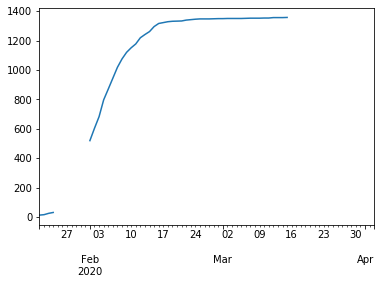

In [4]:
ts.plot()
plt.show()

In [6]:
df = pd.read_csv('CasesDeathsRecoveredFrance.csv', index_col=0)

In [7]:
df.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20
cases,France,0.0,0.0,2.0,3.0,3.0,3.0,4.0,5.0,5.0,...,154188.0,156921.0,154715.0,157026.0,158636.0,160292.0,160847.0,164589.0,167605.0,165093.0
deaths,France,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20265.0,20796.0,21340.0,21856.0,22245.0,22614.0,22856.0,23293.0,23660.0,24087.0
recovered,France,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37409.0,39181.0,40657.0,42088.0,43493.0,44594.0,44903.0,45513.0,46886.0,48228.0


In [8]:
df = df.drop(columns=['Country/Region'])
time_index = pd.to_datetime(df.columns)
data = df.iloc[0, :].values

ts = pd.Series(data = data, index = time_index) 

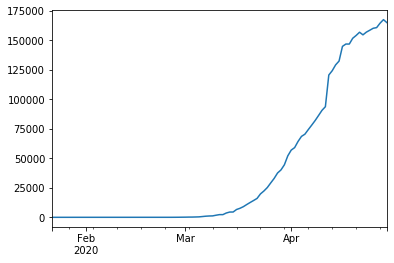

In [9]:
ts.plot()

In [10]:
ts_num = pd.to_numeric(ts.index)
t0 = ts_num[0]
t_days = (ts_num-t0)/(10**9*86400)
t_days = t_days.astype(int).values

In [11]:
t_days

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98],
      dtype=int64)

Data cleaning

In [49]:
ts_clean = ts.dropna()
# Extract data
ts_fit = ts_clean['2020-01-21':"2020-02-12"]
# Convert index to numeric
ts_num = pd.to_numeric(ts_fit.index)
t0 = ts_num[0]
# Convert datetime to days
t_days = (ts_num-t0)/(10**9*86400)
t_days = t_days.astype(int).values
# t_days is an input for SIR

In [73]:
# Define the X number
nX = ts_fit.values # Number of infected
N = 104.3e6 # Population size of Guangdong

In [23]:
# Define the X number
nX = ts.values # Number of infected
N = 65000000 # Population size of Guangdong

Exploration of the dataset

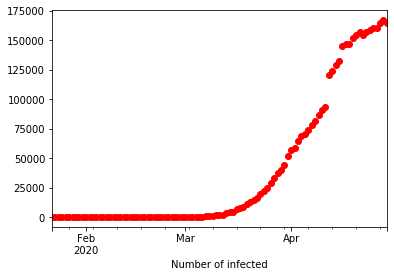

In [24]:
ts.plot(style='ro')
plt.xlabel("Number of infected")
plt.show()

The missing data between the 25th of January and the 31st of January doesn't prevent to fit the SIR-X model

### Setting up SIR and SIR-X models

The population $N$ of the city is a necessary input for the model. In this notebook, this was hardocded, but it can be sourced directly from a web source.

Note that whilst the SIR model estimates directly the number of infected people, $N I(t)$, SIR-X estimates the number of infected people based on the number of tested cases that are in quarantine or in an hospital $N X(t)$

In [25]:
# These lines are required only if opensir wasn't installed using pip install, or if opensir is running in the pipenv virtual environment
import sys
path_opensir = './'
sys.path.append(path_opensir)

# Import SIR and SIRX models
from opensir.models import SIR, SIRX
nX = ts.values # Number of observed infections of the time series
N = 104.3e6 # Population size of Guangdong
params = [0.95, 0.38]
w0 = (N-nX[0], nX[0], 0)

G_sir = SIR()
G_sir.set_params(p=params, initial_conds=w0)
G_sir.fit_input=2
G_sir.fit(t_days, nX, N)
G_sir.solve(t_days[-1], t_days[-1]+1)
t_SIR = G_sir.fetch()[:,0]
I_SIR = G_sir.fetch()[:,2]

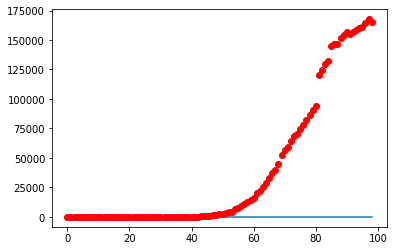

In [26]:
plt.plot(t_SIR, I_SIR)
plt.plot(t_days, nX, 'ro')
plt.show()

The SIR model is clearly not appropriate to fit this data. We will repeat the process with a SIR-X model

In [27]:
g_sirx = SIRX()
params = [6.2/8, 1/8, 0.05, 0.05, 5]
# X_0 can be directly ontained from the statistics
n_x0 = nX[0]            # Number of people tested positive
n_i0 = nX[0]

w0 = (N-n_x0-n_i0, n_i0, 0, n_x0)
g_sirx.set_params(p=params, initial_conds=w0)
# Fit all parameters
fit_index=[False, False, True, True, True]
g_sirx.fit(t_days, nX, N, fit_index = fit_index)
g_sirx.solve(t_days[-1], t_days[-1]+1)
t_sirx = g_sirx.fetch()[:,0]
inf_sirx = g_sirx.fetch()[:,4]

In [28]:
g_sirx.p

array([0.775, 0.125, 0.05 , 0.05 , 5.   ])

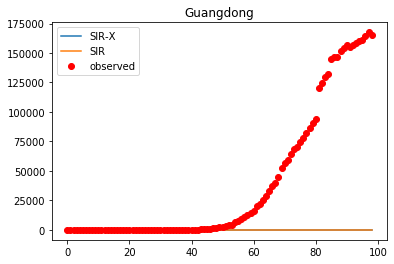

In [29]:
plt.plot(t_sirx, inf_sirx)
plt.plot(t_SIR, I_SIR)
plt.plot(t_days, nX, 'ro')
plt.legend(["SIR-X", "SIR", "observed"])
plt.title("Guangdong")
plt.show()

After fitting the parameters, the effective infectious period $T_{I,eff}$ and the effective reproduction rate $R_{0,eff}$ can be obtained from the model properties

$$ T_{I,eff} = (\beta + \kappa + \kappa_0)^{-1} $$
$$ R_{0,eff} = \alpha T_{I,eff}$$

Aditionally, the Public containment leverage $P$ and the quarantine probability $Q$ can be calculated through:

$$ P = \frac{\kappa_0}{\kappa_0 + \kappa} $$
$$ Q = \frac{\kappa_0 + \kappa}{\beta + \kappa_0 + \kappa} $$

In [20]:
print("Effective infectious period T_I_eff =  %.2f days " % g_sirx.t_inf_eff )
print("Effective reproduction rate R_0_eff =  %.2f, Maier and Brockmann = %.2f" % (g_sirx.r0_eff, 3.02))
print("Public containment leverage =  %.2f, Maier and Brockmann = %.2f" % (g_sirx.pcl, 0.75))
print("Quarantine probability =  %.2f, Maier and Brockmann = %.2f" % (g_sirx.q_prob, 0.51))

Effective infectious period T_I_eff =  4.44 days 
Effective reproduction rate R_0_eff =  3.44, Maier and Brockmann = 3.02
Public containment leverage =  0.50, Maier and Brockmann = 0.75
Quarantine probability =  0.44, Maier and Brockmann = 0.51


Now we can use the model to predict when the peak will occur and what will be the maximum number of infected

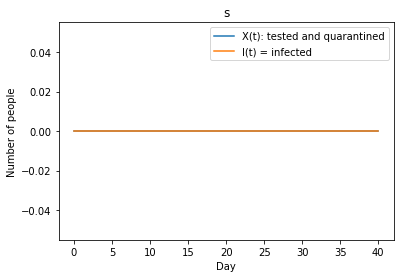

In [22]:
# Predict
g_sirx.solve(40,41)
# Plot
plt.plot(g_sirx.fetch()[:,4]) # X(t)
plt.plot(g_sirx.fetch()[:,2]) # I(t)
plt.xlabel('Day')
plt.ylabel('Number of people')
plt.legend(["X(t): tested and quarantined","I(t) = infected"])
plt.title('s')
plt.show()

The model was trained with a limited amount of data. It is clear to observe that since the measures took place in Guangdong, at least 6 weels pf quarantine were necessary to control the pandemics. Note that a limitation of this model is that it predicts an equilibrium where the number of infected is 0 after a short time. In reality, this amount will decrease to a small number. What we see in the TV is the X(t) curve. After the curve "flattens", it is necessary to keep quarantine for more time and perform effective contact tracing of the remainder of the infected people who hasn't recovered yet.